# Importing Needed Libraries

In [2]:
import pandas as pd
import numpy as np
import tweepy
import requests
import json
import re
import matplotlib.pyplot as plt
import datetime
import os
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# First Step : Gathering Data

### From Twitter Archive File

In [3]:
twitter_archive= pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
#Testing
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### From Image Predictions File

In [5]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)

In [6]:
image_predictions = url.split('/')[-1]

In [7]:
with open(image_predictions, 'wb') as f:
    f.write(r.content)

In [8]:
image_predictions = pd.read_csv('image-predictions.tsv', sep ='\t')

In [9]:
#Testing
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


## From Twitter API (JSON File)
#### i used the given file because 

In [10]:

df_list = []

with open('tweet-json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        user_count = tweet['user']['followers_count']
        df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count,
                       'user_count': user_count})

#Testing        
df_json = pd.DataFrame(df_list)
df_json.sample(10)

,favorite_count,retweet_count,tweet_id,user_count
1208,4719,1813,715680795826982913,3200945
2011,1956,1089,672231046314901505,3201006
1306,3022,903,707297311098011648,3200947
825,5980,1969,769212283578875904,3200906
2013,2414,1270,672205392827572224,3201006
1718,3955,1972,680145970311643136,3200953
427,9718,2320,821149554670182400,3200894
2085,780,262,670797304698376195,3201008
695,11957,2996,786664955043049472,3200901
1503,8910,4732,691793053716221953,3200950


# Second Step : Assessing Data
   we are looking for two types of issues:
 - 1)Low Data Quality
 - 2)Untidy Data

### 1st) Twitter Archive

In [18]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [19]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [20]:
twitter_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [21]:
twitter_archive.shape

(2356, 17)

In [22]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [23]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [24]:
# checking for number of duplicates in twitter_archive
sum(twitter_archive.duplicated())

0

In [25]:
#checking all the sources
twitter_archive['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [26]:
twitter_archive['rating_denominator'].value_counts().sort_index()

0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

In [27]:
twitter_archive['rating_numerator'].value_counts().sort_index()

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

### Documentation
#### Quality Issues:
- 1)There is many columns that will not be used for analysis.
- 2)Timestamp need to be separated into day,month,year. and its data type object instead of datetime.
- 3)tweet_id is better to be string not intger because we will not do calculations on it.
#### Structure Issues:
- 1) Dog Stages separated into 4 columns (doggo, floofer, pupper and puppo columns).
- 2) All data is related but divided into 3 files and should be combined in one file only.

### 2nd) Image Predictions

In [28]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [29]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [30]:
image_predictions.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [31]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [32]:
image_predictions.shape

(2075, 12)

In [33]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [34]:
sum(image_predictions.jpg_url.duplicated()==True)

66

### Documentation:

#### Quality Issues:
- 1) There are missing images for some tweets (2356 - 2075 = 281).
- 2) Columns name has no meaning.
- 3) Unnecessary columns as img_num.
- 4) In p1,p2,p3 names separated by underscore instead of spaces.
- 5) some names start with uppercase and other with lowercase.
- 6) there is duplicated jpg

### 3rd) JSON File

In [35]:
df_json

,favorite_count,retweet_count,tweet_id,user_count
0,39467,8853,892420643555336193,3200889
1,33819,6514,892177421306343426,3200889
2,25461,4328,891815181378084864,3200889
3,42908,8964,891689557279858688,3200889
4,41048,9774,891327558926688256,3200889
5,20562,3261,891087950875897856,3200889
6,12041,2158,890971913173991426,3200889
7,56848,16716,890729181411237888,3200889
8,28226,4429,890609185150312448,3200889
9,32467,7711,890240255349198849,3200889


In [36]:
df_json.head()

,favorite_count,retweet_count,tweet_id,user_count
0,39467,8853,892420643555336193,3200889
1,33819,6514,892177421306343426,3200889
2,25461,4328,891815181378084864,3200889
3,42908,8964,891689557279858688,3200889
4,41048,9774,891327558926688256,3200889


In [37]:
df_json.tail()

,favorite_count,retweet_count,tweet_id,user_count
2349,111,41,666049248165822465,3201018
2350,311,147,666044226329800704,3201018
2351,128,47,666033412701032449,3201018
2352,132,48,666029285002620928,3201018
2353,2535,532,666020888022790149,3201018


In [38]:
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null int64
user_count        2354 non-null int64
dtypes: int64(4)
memory usage: 73.6 KB


In [39]:
df_json.describe()

,favorite_count,retweet_count,tweet_id,user_count
count,2354.000000,2354.000000,2.354000e+03,2.354000e+03
mean,8080.968564,3164.797366,7.426978e+17,3.200942e+06
std,11814.771334,5284.770364,6.852812e+16,4.457302e+01
min,0.000000,0.000000,6.660209e+17,3.200799e+06
25%,1415.000000,624.500000,6.783975e+17,3.200898e+06
50%,3603.500000,1473.500000,7.194596e+17,3.200945e+06
75%,10122.250000,3652.000000,7.993058e+17,3.200953e+06
max,132810.000000,79515.000000,8.924206e+17,3.201018e+06


In [40]:
df_json['tweet_id'].isnull().sum()

0

### Documentation
 #### Quality
- 1)twitter_archive has 2356 tweet_id and JSON file 2354 ( number of missing IDs = 2356-2354 = 2)

# Here is the summary of issues to be cleaned
## Tidiness Issues:
- 1) Dog Stages separated into 4 columns (doggo, floofer, pupper and puppo columns).
- 2) All data is related but divided into 3 files and should be combined in one file only And they have different number of rows.

## Quality Issues: 
- 1)There is many columns that will not be used for analysis.
- 2)Timestamp need to be separated into day,month,year. and its data type object instead of datetime.
- 3)tweet_id is better to be string not intger because we will not do calculations on it.
- 4) There are missing images for some tweets (2356 - 2075 = 281).
- 5) Columns name has no meaning.
- 6) Unnecessary columns as img_num.
- 7) In p1,p2,p3 names separated by underscore instead of spaces.
- 8) some names start with uppercase and other with lowercase.
- 9) there is duplicated jpg
- 10) Rating does not extracted correctly their data type must be float instead of intger.

# Third Step : Cleaning Data

In [12]:
# Making copy from the three files
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
df_json_clean = df_json.copy()

In [13]:
# for testing copied files
#twitter_archive_clean.shape
#image_predictions_clean.shape
#df_json_clean.shape

## Twitter Archive Cleaning

### Define:
Delete columns that will not be used => 'in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp'

### Code

In [14]:
# twitter_archive_clean.columns
twitter_archive_clean = twitter_archive_clean.drop(['in_reply_to_status_id',
                                                    'in_reply_to_user_id',
                                                    'retweeted_status_id',
                                                    'retweeted_status_user_id', 
                                                    'retweeted_status_timestamp'], 1)

### Test

In [15]:
twitter_archive_clean.columns
twitter_archive_clean.sample(5)
#twitter_archive_clean.shape

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
971,750101899009982464,2016-07-04 23:00:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Lilah. She agreed on one quick pic. Now s...,https://twitter.com/dog_rates/status/750101899...,11,10,Lilah,None,None,None,None
83,876537666061221889,2017-06-18 20:30:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I can say with the pupmost confidence that the...,https://twitter.com/mpstowerham/status/8761629...,14,10,None,None,None,None,None
256,843981021012017153,2017-03-21 00:22:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",HE WAS DOING A SNOOZE NO SHAME IN A SNOOZE 13/...,https://twitter.com/brianstack153/status/79679...,13,10,None,None,None,None,None
714,784057939640352768,2016-10-06 15:49:14 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Balto. He's very content. Legendary to...,https://vine.co/v/5gKxeUpuKEr,12,10,Balto,None,None,None,None
70,879008229531029506,2017-06-25 16:07:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Beau. That is Beau's balloon. He takes...,https://twitter.com/dog_rates/status/879008229...,13,10,Beau,None,None,None,None


### Define:
Merge doggo, floofer, pupper and puppo columns to dogs_stage column.
Then drop those columns.

### Code

In [16]:
# handling none by making them empty
twitter_archive_clean.iloc[:, -4:  ] = twitter_archive_clean.iloc[:, -4:  ].replace('None','')


In [17]:
#add the columns together to form a new column named 'dog_stage'
twitter_archive_clean['dog_stage'] = twitter_archive_clean.doggo + twitter_archive_clean.floofer + twitter_archive_clean.pupper + twitter_archive_clean.puppo

In [18]:
#Drop the old columns
twitter_archive_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)


In [19]:

# Fixing the empty string issue for more accurate representation of vlues
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == "", 'dog_stage'] = np.nan


In [20]:
# Separating the stacked stages
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo-pupper'
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo-puppo'
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo-floofer'

### Test

In [21]:
twitter_archive_clean.dog_stage.value_counts(dropna = False)

NaN              1976
pupper            245
doggo              83
puppo              29
doggo-pupper       12
floofer             9
doggo-floofer       1
doggo-puppo         1
Name: dog_stage, dtype: int64

### Define:
convert timestamp to datetime. Then extract year, month and day to new columns. Then drop timestamp column.

### Code:

In [22]:
## twitter_archive_clean.info()
#convert timestamp to datetime
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

In [23]:
#extract year, month and day to new columns
twitter_archive_clean['year'] = twitter_archive_clean['timestamp'].dt.year
twitter_archive_clean['month'] = twitter_archive_clean['timestamp'].dt.month
twitter_archive_clean['day'] = twitter_archive_clean['timestamp'].dt.day

In [24]:
#drop timestamp column
twitter_archive_clean = twitter_archive_clean.drop('timestamp', 1)

### Test

In [25]:
twitter_archive_clean.info()
twitter_archive_clean.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2356 non-null int64
source                2356 non-null object
text                  2356 non-null object
expanded_urls         2297 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
dog_stage             380 non-null object
year                  2356 non-null int64
month                 2356 non-null int64
day                   2356 non-null int64
dtypes: int64(6), object(5)
memory usage: 202.5+ KB


,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,year,month,day
598,798686750113755136,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: Say hello to Jack (pronounced ""...",https://twitter.com/dog_rates/status/683391852...,11,10,Jack,NaN,2016,11,16


## Image Predictions file Cleaning

### Define 
Replace underscores with white space in p1,p2 and p3 columns.

### Code

In [26]:
image_predictions_clean.p1= image_predictions_clean.p1.str.replace('_',' ')
image_predictions_clean.p2= image_predictions_clean.p2.str.replace('_',' ')
image_predictions_clean.p3= image_predictions_clean.p3.str.replace('_',' ')

### Test

In [27]:
image_predictions_clean.p1.head()

0    Welsh springer spaniel
1                   redbone
2           German shepherd
3       Rhodesian ridgeback
4        miniature pinscher
Name: p1, dtype: object

In [28]:
image_predictions_clean.p2.head()

0                collie
1    miniature pinscher
2              malinois
3               redbone
4            Rottweiler
Name: p2, dtype: object

In [29]:
image_predictions_clean.p3.head()

0      Shetland sheepdog
1    Rhodesian ridgeback
2             bloodhound
3     miniature pinscher
4               Doberman
Name: p3, dtype: object

### Define
Convert first lowercase to uppercase

### Code 

In [30]:
image_predictions_clean.p1 = image_predictions_clean.p1.str.title()
image_predictions_clean.p2 = image_predictions_clean.p2.str.title()
image_predictions_clean.p3 = image_predictions_clean.p3.str.title()

### Test

In [31]:
image_predictions_clean.p1.head()

0    Welsh Springer Spaniel
1                   Redbone
2           German Shepherd
3       Rhodesian Ridgeback
4        Miniature Pinscher
Name: p1, dtype: object

In [32]:
image_predictions_clean.p2.head()

0                Collie
1    Miniature Pinscher
2              Malinois
3               Redbone
4            Rottweiler
Name: p2, dtype: object

In [33]:
image_predictions_clean.p3.sample(10)

910            Maltese Dog
1902                Pillow
630                 Beagle
628             Pomeranian
97      Labrador Retriever
1730       Tibetan Mastiff
1596              Malamute
908             Great Dane
557       Golden Retriever
363                 Borzoi
Name: p3, dtype: object

### Define
Drop column img_num as it will not be used in anaylsis

### Code

In [34]:
image_predictions_clean.drop('img_num', axis=1, inplace=True)

### Test

In [35]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 11 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 135.8+ KB


### Define
Rename the undescriptive column names

### Code 

In [36]:
image_predictions_clean = image_predictions_clean.rename(columns={"p1": "prediction_1", "p2": "prediction_2", "p3":"prediction_3",
                                       "p1_conf":"confidence_1" ,"p2_conf":"confidence_2" ,"p3_conf":"confidence_2"})

In [37]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 11 columns):
tweet_id        2075 non-null int64
jpg_url         2075 non-null object
prediction_1    2075 non-null object
confidence_1    2075 non-null float64
p1_dog          2075 non-null bool
prediction_2    2075 non-null object
confidence_2    2075 non-null float64
p2_dog          2075 non-null bool
prediction_3    2075 non-null object
confidence_2    2075 non-null float64
p3_dog          2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 135.8+ KB


# Merging the three files and fixing them together

### Define
Merging files into one master file based on tweet_id

In [38]:
master_clean =pd.merge(twitter_archive_clean, image_predictions_clean, on='tweet_id', how='left')

In [39]:
master_clean =pd.merge(master_clean, df_json_clean, on='tweet_id', how='left')

### Test

In [40]:
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 24 columns):
tweet_id              2356 non-null int64
source                2356 non-null object
text                  2356 non-null object
expanded_urls         2297 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
dog_stage             380 non-null object
year                  2356 non-null int64
month                 2356 non-null int64
day                   2356 non-null int64
jpg_url               2075 non-null object
prediction_1          2075 non-null object
confidence_1          2075 non-null float64
p1_dog                2075 non-null object
prediction_2          2075 non-null object
confidence_2          2075 non-null float64
p2_dog                2075 non-null object
prediction_3          2075 non-null object
confidence_2          2075 non-null float64
p3_dog                2075 non-null o

In [41]:
master_clean.head(1)

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,year,month,...,p1_dog,prediction_2,confidence_2,p2_dog,prediction_3,confidence_2,p3_dog,favorite_count,retweet_count,user_count
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,2017,8,...,False,Bagel,0.085851,False,Banana,0.07611,False,39467.0,8853.0,3200889.0


### Define
Convert tweet_id datatype from int to string (object)

### Code

In [42]:
master_clean.tweet_id = master_clean.tweet_id.astype(str)

### Test

In [43]:
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 24 columns):
tweet_id              2356 non-null object
source                2356 non-null object
text                  2356 non-null object
expanded_urls         2297 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
dog_stage             380 non-null object
year                  2356 non-null int64
month                 2356 non-null int64
day                   2356 non-null int64
jpg_url               2075 non-null object
prediction_1          2075 non-null object
confidence_1          2075 non-null float64
p1_dog                2075 non-null object
prediction_2          2075 non-null object
confidence_2          2075 non-null float64
p2_dog                2075 non-null object
prediction_3          2075 non-null object
confidence_2          2075 non-null float64
p3_dog                2075 non-null 

### Define
Delete rows with no images

### Code

In [44]:
master_clean = master_clean[master_clean.jpg_url.notnull()]

In [45]:
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2355
Data columns (total 24 columns):
tweet_id              2075 non-null object
source                2075 non-null object
text                  2075 non-null object
expanded_urls         2075 non-null object
rating_numerator      2075 non-null int64
rating_denominator    2075 non-null int64
name                  2075 non-null object
dog_stage             321 non-null object
year                  2075 non-null int64
month                 2075 non-null int64
day                   2075 non-null int64
jpg_url               2075 non-null object
prediction_1          2075 non-null object
confidence_1          2075 non-null float64
p1_dog                2075 non-null object
prediction_2          2075 non-null object
confidence_2          2075 non-null float64
p2_dog                2075 non-null object
prediction_3          2075 non-null object
confidence_2          2075 non-null float64
p3_dog                2075 non-null 

### Define
Delete duplicated rows based on jpg

### Code

In [46]:
#sum(master_clean['jpg_url'].duplicated())
master_clean = master_clean.drop_duplicates(subset=['jpg_url'], keep='last')

### Test

In [47]:
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2355
Data columns (total 24 columns):
tweet_id              2009 non-null object
source                2009 non-null object
text                  2009 non-null object
expanded_urls         2009 non-null object
rating_numerator      2009 non-null int64
rating_denominator    2009 non-null int64
name                  2009 non-null object
dog_stage             310 non-null object
year                  2009 non-null int64
month                 2009 non-null int64
day                   2009 non-null int64
jpg_url               2009 non-null object
prediction_1          2009 non-null object
confidence_1          2009 non-null float64
p1_dog                2009 non-null object
prediction_2          2009 non-null object
confidence_2          2009 non-null float64
p2_dog                2009 non-null object
prediction_3          2009 non-null object
confidence_2          2009 non-null float64
p3_dog                2009 non-null 

In [48]:
master_clean[master_clean.user_count.isnull()]

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,year,month,...,p1_dog,prediction_2,confidence_2,p2_dog,prediction_3,confidence_2,p3_dog,favorite_count,retweet_count,user_count
815,771004394259247104,"<a href=""http://twitter.com/download/iphone"" r...",RT @katieornah: @dog_rates learning a lot at c...,https://twitter.com/katieornah/status/77100213...,12,10,None,pupper,2016,8,...,False,Ipod,0.052741,False,Pop Bottle,0.048821,False,NaN,NaN,NaN


### Define 
Change datatype of rating_numerator to float and extract it correctly.

### Code

In [49]:
#extracting it from tweets
rating_numerator_float = master_clean[master_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]['text'].str.extract(r"(\d+\.\d*(?=\/\d+))")
rating_numerator_float

,0
45,13.5
695,9.75
763,11.27
1712,11.26


In [50]:
master_clean.loc[rating_numerator_float.index]['rating_numerator']

45       5
695     75
763     27
1712    26
Name: rating_numerator, dtype: int64

In [51]:
master_clean.loc[rating_numerator_float.index, 'rating_numerator'] = rating_numerator_float.values

In [52]:
master_clean.rating_numerator= master_clean.rating_numerator.astype(float)

### Test

In [53]:
master_clean.loc[rating_numerator_float.index]['rating_numerator']

45      13.50
695      9.75
763     11.27
1712    11.26
Name: rating_numerator, dtype: float64

In [55]:
master_clean.sample(5)

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,year,month,...,p1_dog,prediction_2,confidence_2,p2_dog,prediction_3,confidence_2,p3_dog,favorite_count,retweet_count,user_count
1304,707411934438625280,"<a href=""http://twitter.com/download/iphone"" r...","""I shall trip the big pupper with leash. Big p...",https://twitter.com/dog_rates/status/707411934...,11.0,10,None,pupper,2016,3,...,True,Airedale,0.028515,True,Giant Schnauzer,0.024876,True,2486.0,673.0,3200947.0
172,858843525470990336,"<a href=""http://twitter.com/download/iphone"" r...",I have stumbled puppon a doggo painting party....,https://twitter.com/dog_rates/status/858843525...,13.0,10,None,doggo,2017,5,...,True,Labrador Retriever,0.286059,True,Bloodhound,0.026917,True,16304.0,3771.0,3200891.0
24,887343217045368832,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,https://twitter.com/dog_rates/status/887343217...,13.0,10,None,NaN,2017,7,...,True,Sea Lion,0.275645,False,Weimaraner,0.134203,True,34222.0,10737.0,3200890.0
2193,668902994700836864,"<a href=""http://twitter.com/download/iphone"" r...",Meet Lambeau. He's a Whistling Haiku from the ...,https://twitter.com/dog_rates/status/668902994...,11.0,10,Lambeau,NaN,2015,11,...,True,Ibizan Hound,0.043082,True,Blenheim Spaniel,0.028004,True,338.0,107.0,3201014.0
2266,667530908589760512,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Meet Naphaniel. He doesn't necessarily enjoy h...,https://twitter.com/dog_rates/status/667530908...,10.0,10,Naphaniel,NaN,2015,11,...,True,Kuvasz,0.146391,True,Labrador Retriever,0.046184,True,501.0,264.0,3201016.0


### Define 
Delete row manually that has null values in user_count

### Code

In [56]:
master_clean = master_clean[master_clean.user_count.notnull()]

### Test

In [57]:
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2008 entries, 0 to 2355
Data columns (total 24 columns):
tweet_id              2008 non-null object
source                2008 non-null object
text                  2008 non-null object
expanded_urls         2008 non-null object
rating_numerator      2008 non-null float64
rating_denominator    2008 non-null int64
name                  2008 non-null object
dog_stage             309 non-null object
year                  2008 non-null int64
month                 2008 non-null int64
day                   2008 non-null int64
jpg_url               2008 non-null object
prediction_1          2008 non-null object
confidence_1          2008 non-null float64
p1_dog                2008 non-null object
prediction_2          2008 non-null object
confidence_2          2008 non-null float64
p2_dog                2008 non-null object
prediction_3          2008 non-null object
confidence_2          2008 non-null float64
p3_dog                2008 non-nul

# Data Storing

In [58]:
master_clean.to_csv('twitter_archive_master.csv')

# Data Analysis and Visualization

### 1)Relationship between retweet count and favorite count

Text(0,0.5,'Favorite count')

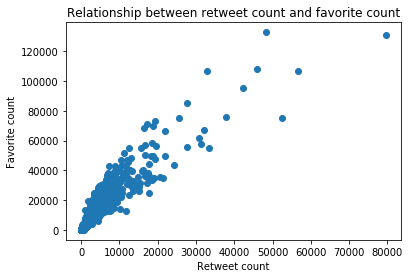

In [59]:
plt.scatter(master_clean.retweet_count , master_clean.favorite_count)
plt.title("Relationship between retweet count and favorite count")
plt.xlabel("Retweet count")
plt.ylabel("Favorite count")

**Insights**: There is a linear relationship between both retweet count and favorite count

## 2)The percentage of different dog stages

In [60]:
stages = master_clean.dog_stage.value_counts()
stages
#plt.pie(master_clean.dog_stage)

pupper           206
doggo             63
puppo             22
doggo-pupper       9
floofer            7
doggo-floofer      1
doggo-puppo        1
Name: dog_stage, dtype: int64

(-1.2149995118190318,
 1.3149891488143355,
 -1.3364308466454287,
 1.2927115555594497)

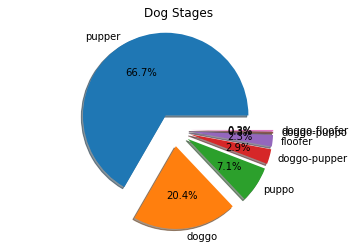

In [61]:
plt.pie(stages,
       labels= ['pupper','doggo','puppo','doggo-pupper','floofer','doggo-puppo','doggo-floofer'],
       autopct= '%1.1f%%',
       shadow= True,
       explode= (0.2,0.2,0.2,0.2,0.2,0.2,0.2))
plt.title('Dog Stages')
plt.axis('equal')

**Insights:** it appears that pupper has the greatest percentage and doggo followed it.

## 3)The Relationship between numbers of tweets about dogs and years

In [62]:
master_clean.groupby('year').count()

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,month,day,...,p1_dog,prediction_2,confidence_2,p2_dog,prediction_3,confidence_2,p3_dog,favorite_count,retweet_count,user_count
year,,,,,,,,,,,,,,,,,,,,,
2015,665,665,665,665,665,665,665,63,665,665,...,665,665,665,665,665,665,665,665,665,665
2016,977,977,977,977,977,977,977,182,977,977,...,977,977,977,977,977,977,977,977,977,977
2017,366,366,366,366,366,366,366,64,366,366,...,366,366,366,366,366,366,366,366,366,366


**Insights:** It Appears that the most year has tweets is 2016